## Features from Bergholz et al; 2012

1. l_numexternal = Number of external links
2. l_numdeceptive = Number of deceptive links
3. l_sus = Suspicious words in link text
4. l_numip = Links with IP addresses

## Features from Khonji et al; 2012 ##

1.   b_dear = Binaray feature that returns 1 if word "dear" is found in the body of the message , else 0
2.   b_form = Does the message contain HTML form? (binary)
3. b_numwords = Total number of words found in body (cont.)
4. b_numchr = Total number of characters found in body (cont.)
5. b_numunique = A feature that returns the
total number of unique words found in the body a given
email message
6. b_numfunct = A feature that returns
the total number of function words found in the body of
a given email



## Overall Goal:
Identify if the following features from the academic papers can help us increase accuracy in our models

In [29]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import email
from datetime import datetime
from wordcloud import WordCloud
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import matplotlib.ticker as ticker

In [30]:
print(os.getcwd())

C:\Program Files\JetBrains\PyCharm 2024.3.4\bin


In [31]:
df_train = pd.read_csv('D:\\phishing_repo_thesis\\balanced_data_files\\train_raw.csv')
df_test = pd.read_csv('D:\\phishing_repo_thesis\\balanced_data_files\\test_raw.csv')
df_val = pd.read_csv('D:\\phishing_repo_thesis\\balanced_data_files\\val_raw.csv')

In [32]:
# making new dataset with neccesary features
# Cell 2: Extract features from each dataset

def extract_features(df):
    # Initialize a dataframe to store features
    features_df = pd.DataFrame()

    # 1. b_dear - Binary feature for "dear" in body
    features_df['b_dear'] = df['Email Text'].apply(
        lambda x: 1 if 'dear' in str(x).lower() else 0
    )

    # 2. b_form - Does the message contain HTML form?
    features_df['b_form'] = df['Email Text'].apply(
        lambda x: 1 if '<form' in str(x).lower() else 0
    )

    # 3. b_numwords - Total number of words in body
    features_df['b_numwords'] = df['Email Text'].apply(
        lambda x: len(str(x).split())
    )

    # 4. b_numchr - Total number of characters in body
    features_df['b_numchr'] = df['Email Text'].apply(
        lambda x: len(str(x))
    )

    # 5. b_numunique - Total number of unique words
    features_df['b_numunique'] = df['Email Text'].apply(
        lambda x: len(set(str(x).lower().split()))
    )

    # 6. b_numfunct - Function words in body
    function_words = {
    "account", "access", "bank", "credit", "click", "identity",
    "inconvenience", "information", "limited", "log", "minutes",
    "password", "recently", "risk", "social", "security",
    "service", "suspended"
    }

    features_df['b_numfunct'] = df['Email Text'].apply(
        lambda x: sum(1 for word in str(x).lower().split() if word in function_words)
    )

    # Bergholz features
    def extract_links(html_text):
        try:
            soup = BeautifulSoup(str(html_text), 'html.parser')
            links = soup.find_all('a')
            return links
        except:
            return []

    # 1. l_numexternal - Number of external links
    features_df['l_numexternal'] = df['Email Text'].apply(
        lambda x: len(extract_links(x))
    )

    # 2. l_numdeceptive - Number of deceptive links
    def count_deceptive_links(html_text):
        links = extract_links(html_text)
        deceptive_count = 0

        for link in links:
            if link.has_attr('href') and link.string:
                href = link['href']
                text = link.string.strip()
                if text and not any(part in href.lower() for part in text.lower().split()):
                    deceptive_count += 1

        return deceptive_count

    features_df['l_numdeceptive'] = df['Email Text'].apply(count_deceptive_links)

    # 3. l_sus - Suspicious words in link text
    def count_suspicious_links(html_text):
        links = extract_links(html_text)
        suspicious_words = {'verify', 'account', 'bank', 'confirm', 'secure', 'update',
                           'login', 'password'}

        count = 0
        for link in links:
            if link.string:
                text = link.string.strip().lower()
                if any(word in text for word in suspicious_words):
                    count += 1

        return count

    features_df['l_sus'] = df['Email Text'].apply(count_suspicious_links)

    # 4. l_numip - Links with IP addresses
    def count_ip_links(html_text):
        links = extract_links(html_text)
        ip_pattern = re.compile(r'\d+\.\d+\.\d+\.\d+')

        count = 0
        for link in links:
            if link.has_attr('href'):
                href = link['href']
                if ip_pattern.search(href):
                    count += 1

        return count

    features_df['l_numip'] = df['Email Text'].apply(count_ip_links)

    # Add target variable
    features_df['Email Type'] = df['Email Type']

    return features_df

# Extract features for each dataset
train_features = extract_features(df_train)
val_features = extract_features(df_val)
test_features = extract_features(df_test)

# Display feature statistics
print("Training set features shape:", train_features.shape)
print("Validation set features shape:", val_features.shape)
print("Test set features shape:", test_features.shape)

# Display some sample data
print("\nSample of training features:")
print(train_features.head())

# Check for any missing values
print("\nMissing values in training set:")
print(train_features.isnull().sum())

C:\Users\alfar\AppData\Local\Temp\ipykernel_23852\2367339296.py:48: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  soup = BeautifulSoup(str(html_text), 'html.parser')
C:\Users\alfar\AppData\Local\Temp\ipykernel_23852\23

Training set features shape: (13054, 11)
Validation set features shape: (2798, 11)
Test set features shape: (2798, 11)

Sample of training features:
   b_dear  b_form  b_numwords  b_numchr  b_numunique  b_numfunct  \
0       0       0         142       983          107           1   
1       0       0         291      3130          175           1   
2       0       0          42       221           35           0   
3       0       0          44       187           36           0   
4       0       0           6        34            6           0   

   l_numexternal  l_numdeceptive  l_sus  l_numip      Email Type  
0              0               0      0        0  Phishing Email  
1              0               0      0        0      Safe Email  
2              0               0      0        0      Safe Email  
3              0               0      0        0      Safe Email  
4              0               0      0        0  Phishing Email  

Missing values in training set:
b_dear 

In [48]:
print(train_features.columns)
print(train_features.head(10))

Index(['b_dear', 'b_form', 'b_numwords', 'b_numchr', 'b_numunique',
       'b_numfunct', 'l_numexternal', 'l_numdeceptive', 'l_sus', 'l_numip',
       'Email Type'],
      dtype='object')
   b_dear  b_form  b_numwords  b_numchr  b_numunique  b_numfunct  \
0       0       0         142       983          107           1   
1       0       0         291      3130          175           1   
2       0       0          42       221           35           0   
3       0       0          44       187           36           0   
4       0       0           6        34            6           0   
5       0       0           6       152            6           0   
6       0       0           1         5            1           0   
7       0       0         100       521           74           3   
8       0       0          20       128           18           0   
9       0       0          90       509           74           0   

   l_numexternal  l_numdeceptive  l_sus  l_numip      Email Typ

Dataset Distribution
Email Type
Safe Email        7924
Phishing Email    5130
Name: count, dtype: int64


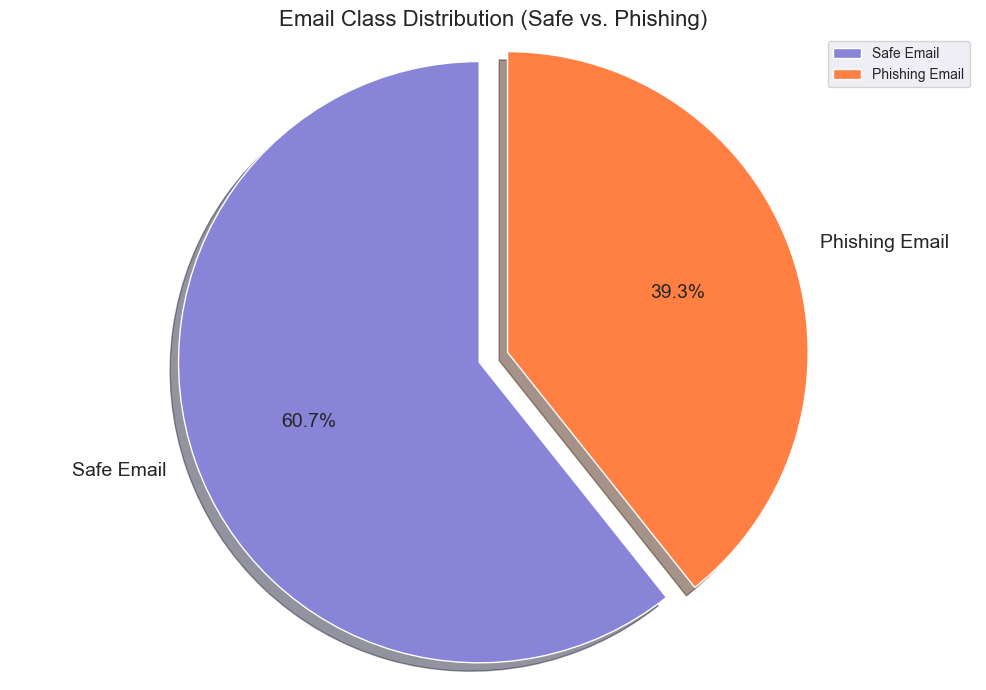

In [34]:
# EDA (Exploratory Data Analysis)

print("Dataset Distribution")

class_counts = train_features['Email Type'].value_counts()
print(class_counts)

# pie chart
plt.figure(figsize=(10, 7))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90,
        colors=['#8884d8', '#FF8042'], explode=(0, 0.1), shadow=True, textprops={'fontsize': 14})

plt.axis('equal')
plt.title('Email Class Distribution (Safe vs. Phishing)', fontsize=16)
plt.legend(class_counts.index, loc="best")
plt.tight_layout()
plt.show()

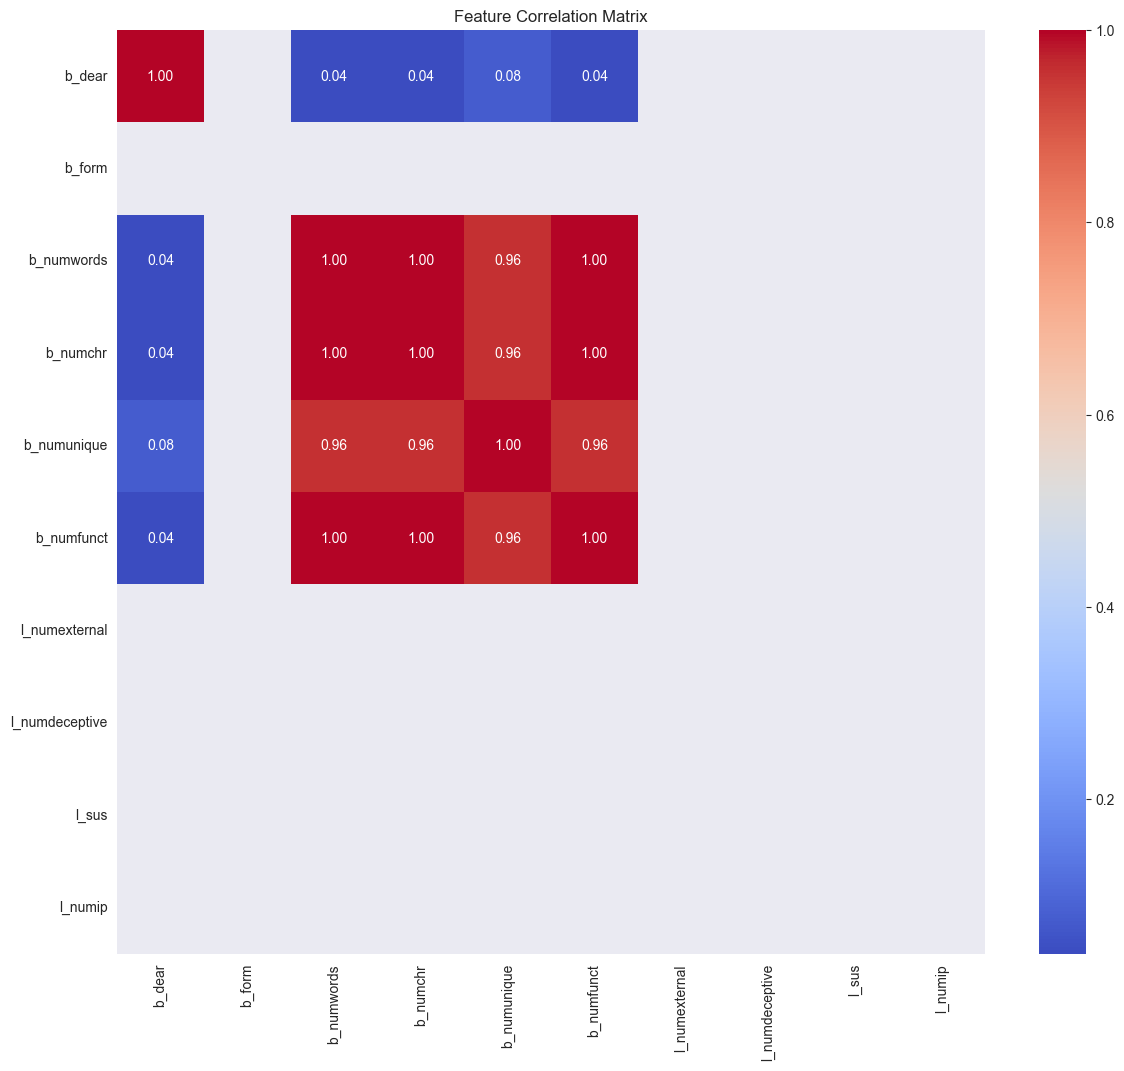

In [47]:
# Correlation matrix
plt.figure(figsize=(14, 12))
corr = train_features.drop('Email Type', axis=1).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()